In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
zip_rgb_pm_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Dataset/SLP_Dataset_RGB_PM/RGM_PM(Train_Val).zip'
unzip_rgb_pm_path = '/content/RGB_PM'

os.makedirs(unzip_rgb_pm_path, exist_ok=True)
with zipfile.ZipFile(zip_rgb_pm_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_rgb_pm_path)

# 데이터셋

In [ ]:
class RGB_PM_Dataset_Regression(Dataset):
    """
    RGB 이미지와 압력맵(PM) 이미지를 불러와서 변환하는 데이터셋 클래스입니다.
    압력맵 이미지를 회귀 예측에 활용할 수 있도록, 배경(압력이 없는 곳)과 사람(압력이 있는 곳) 간의 압력 차이가 명확히 나타날 수 있도록 밝기 조정을 수행합니다.
    """
    def __init__(self, rgb_pm_folder, rgb_transform=None, pm_transform=None):
        self.rgb_pm_folder = rgb_pm_folder

        self.rgb_images = sorted([f for f in os.listdir(self.rgb_pm_folder) if f.endswith('.jpg')])
        self.pm_images = sorted([f for f in os.listdir(self.rgb_pm_folder) if f.endswith('.png')])

        self.rgb_transform = rgb_transform
        self.pm_transform = pm_transform

    def __len__(self):
        return len(self.pm_images)

    def __getitem__(self, idx):
        # RGB image
        rgb_path = os.path.join(self.rgb_pm_folder, self.rgb_images[idx])
        rgb_img = Image.open(rgb_path).convert('RGB')
        rgb_img = self.rgb_transform(rgb_img)

        # Pressure map
        pm_path = os.path.join(self.rgb_pm_folder, self.pm_images[idx])
        pm_img = Image.open(pm_path)

        pm_img = np.array(pm_img, dtype=np.float32)
        pm_img = (pm_img - np.min(pm_img)) / (np.max(pm_img) - np.min(pm_img))
        pm_img = np.where(pm_img > 0, pm_img + 0.1, pm_img)
        pm_img = np.clip(pm_img, 0, 1)
        pm_img = self.pm_transform(pm_img)

        return rgb_img, pm_img

In [ ]:
rgb_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((192, 96)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

pm_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((192, 96))])

In [ ]:
val_data_path = os.path.join(unzip_rgb_pm_path, 'Validation')

train_dataset = RGB_PM_Dataset_Regression(unzip_rgb_pm_path, rgb_transform, pm_transform)
val_dataset = RGB_PM_Dataset_Regression(val_data_path, rgb_transform, pm_transform)

In [ ]:
print('Train 샘플 개수:', len(train_dataset))
print('Val 샘플 개수:', len(val_dataset))

Train 샘플 개수: 4050
Val 샘플 개수: 450


In [ ]:
"""
RGB 이미지, 훈련 데이터가 약 4천장이므로, 배치 크기는 16으로 설정
"""

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
print('Train 배치 개수:', len(train_loader))
print('Val 배치 개수:', len(val_loader))

Train 배치 개수: 254
Val 배치 개수: 29


In [ ]:
rgb_sample, pm_sample = next(iter(train_loader))

rgb_sample = rgb_sample[0]
pm_sample = pm_sample[0]

In [ ]:
print('RGB image shape:', rgb_sample.shape)
print('Pressure map shape:', pm_sample.shape)

RGB image shape: torch.Size([3, 192, 96])
Pressure map shape: torch.Size([1, 192, 96])


Text(0.5, 1.0, 'Pressure Map (Ground Truth)')

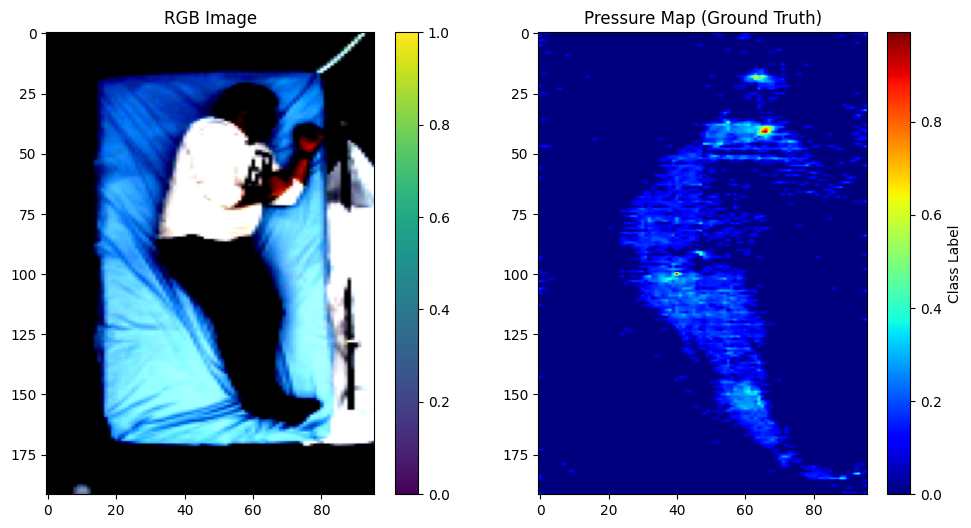

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(rgb_sample.permute(1, 2, 0), aspect='auto')
plt.colorbar()
plt.title('RGB Image')

plt.subplot(1, 3, 2)
plt.imshow(pm_sample.squeeze(0), cmap='jet', aspect='auto')
plt.colorbar(label='Class Label')
plt.title('Pressure Map (Ground Truth)')

# 모델

In [ ]:
"""
U-Net 모델을 생성
encoder_name="resnet50": U-Net의 백본으로 ResNet50을 사용
encoder_weights="imagenet": ResNet50의 가중치는 ImageNet에서 학습된 가중치를 사용
in_channels=3: 입력 이미지 채널 수 (RGB 이미지이므로 3)
classes=1: 출력 클래스 수 (압력값에 대한 회귀 예측이므로 클래스 수는 1)
"""

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

model = model.to(device)

In [ ]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
criterion = nn.MSELoss() # 회귀 예측이므로 MSE 손실 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(data_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(data_loader)

    return train_loss

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()

    eval_loss /= len(data_loader)

    return eval_loss

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)

    end_time = time.time()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, {int(end_time - start_time)}s")
    print(f"Training Loss: {train_loss:.6f} | Validation Loss: {val_loss:.6f}\n")

Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/100, 23s
Training Loss: 0.032737 | Validation Loss: 0.003704



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/100, 23s
Training Loss: 0.004185 | Validation Loss: 0.003311



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/100, 22s
Training Loss: 0.003635 | Validation Loss: 0.003142



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/100, 23s
Training Loss: 0.003385 | Validation Loss: 0.003069



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/100, 23s
Training Loss: 0.003265 | Validation Loss: 0.003102



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/100, 24s
Training Loss: 0.003092 | Validation Loss: 0.002970



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/100, 23s
Training Loss: 0.002954 | Validation Loss: 0.002949



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/100, 23s
Training Loss: 0.002836 | Validation Loss: 0.002870



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/100, 23s
Training Loss: 0.002750 | Validation Loss: 0.002917



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/100, 23s
Training Loss: 0.002680 | Validation Loss: 0.002786



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/100, 23s
Training Loss: 0.002590 | Validation Loss: 0.002783



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/100, 23s
Training Loss: 0.002521 | Validation Loss: 0.002809



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/100, 23s
Training Loss: 0.002458 | Validation Loss: 0.002811



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/100, 23s
Training Loss: 0.002397 | Validation Loss: 0.002676



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15/100, 23s
Training Loss: 0.002340 | Validation Loss: 0.002687



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/100, 22s
Training Loss: 0.002289 | Validation Loss: 0.002711



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/100, 23s
Training Loss: 0.002248 | Validation Loss: 0.002725



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/100, 23s
Training Loss: 0.002190 | Validation Loss: 0.002634



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 19/100, 22s
Training Loss: 0.002141 | Validation Loss: 0.002723



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/100, 22s
Training Loss: 0.002172 | Validation Loss: 0.002647



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 21/100, 23s
Training Loss: 0.002085 | Validation Loss: 0.002896



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 22/100, 22s
Training Loss: 0.002278 | Validation Loss: 0.002561



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 23/100, 22s
Training Loss: 0.002109 | Validation Loss: 0.002605



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 24/100, 22s
Training Loss: 0.002072 | Validation Loss: 0.002572



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 25/100, 22s
Training Loss: 0.002026 | Validation Loss: 0.002517



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 26/100, 23s
Training Loss: 0.001949 | Validation Loss: 0.002546



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 27/100, 23s
Training Loss: 0.001918 | Validation Loss: 0.002520



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 28/100, 22s
Training Loss: 0.001883 | Validation Loss: 0.002537



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 29/100, 23s
Training Loss: 0.001841 | Validation Loss: 0.002543



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 30/100, 22s
Training Loss: 0.001819 | Validation Loss: 0.002533



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 31/100, 23s
Training Loss: 0.001797 | Validation Loss: 0.002529



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 32/100, 22s
Training Loss: 0.001753 | Validation Loss: 0.002583



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 33/100, 22s
Training Loss: 0.001731 | Validation Loss: 0.002493



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 34/100, 23s
Training Loss: 0.001711 | Validation Loss: 0.002545



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 35/100, 22s
Training Loss: 0.001689 | Validation Loss: 0.002639



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 36/100, 22s
Training Loss: 0.001674 | Validation Loss: 0.002548



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 37/100, 23s
Training Loss: 0.001635 | Validation Loss: 0.002541



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 38/100, 23s
Training Loss: 0.001647 | Validation Loss: 0.002488



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 39/100, 23s
Training Loss: 0.001607 | Validation Loss: 0.002484



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 40/100, 23s
Training Loss: 0.001603 | Validation Loss: 0.002507



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 41/100, 23s
Training Loss: 0.001566 | Validation Loss: 0.002497



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 42/100, 23s
Training Loss: 0.001548 | Validation Loss: 0.002502



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 43/100, 23s
Training Loss: 0.001576 | Validation Loss: 0.002496



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 44/100, 23s
Training Loss: 0.001521 | Validation Loss: 0.002724



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 45/100, 23s
Training Loss: 0.001502 | Validation Loss: 0.002516



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 46/100, 23s
Training Loss: 0.001546 | Validation Loss: 0.002493



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 47/100, 23s
Training Loss: 0.001493 | Validation Loss: 0.002538



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 48/100, 23s
Training Loss: 0.001454 | Validation Loss: 0.002464



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 49/100, 23s
Training Loss: 0.001436 | Validation Loss: 0.002487



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 50/100, 23s
Training Loss: 0.001417 | Validation Loss: 0.002611



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 51/100, 23s
Training Loss: 0.001443 | Validation Loss: 0.002540



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 52/100, 23s
Training Loss: 0.001408 | Validation Loss: 0.002602



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 53/100, 23s
Training Loss: 0.001409 | Validation Loss: 0.002512



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 54/100, 23s
Training Loss: 0.001402 | Validation Loss: 0.002462



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 55/100, 23s
Training Loss: 0.001374 | Validation Loss: 0.002486



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 56/100, 23s
Training Loss: 0.001377 | Validation Loss: 0.002444



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 57/100, 23s
Training Loss: 0.001518 | Validation Loss: 0.002512



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 58/100, 23s
Training Loss: 0.001509 | Validation Loss: 0.002461



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 59/100, 23s
Training Loss: 0.001387 | Validation Loss: 0.002446



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 60/100, 23s
Training Loss: 0.001323 | Validation Loss: 0.002472



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 61/100, 23s
Training Loss: 0.001321 | Validation Loss: 0.002537



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 62/100, 23s
Training Loss: 0.001334 | Validation Loss: 0.002591



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 63/100, 23s
Training Loss: 0.001358 | Validation Loss: 0.002767



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 64/100, 23s
Training Loss: 0.001330 | Validation Loss: 0.002461



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 65/100, 23s
Training Loss: 0.001287 | Validation Loss: 0.002791



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 66/100, 23s
Training Loss: 0.001271 | Validation Loss: 0.002537



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 67/100, 23s
Training Loss: 0.001263 | Validation Loss: 0.002444



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 68/100, 23s
Training Loss: 0.001743 | Validation Loss: 0.002494



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 69/100, 23s
Training Loss: 0.001413 | Validation Loss: 0.002475



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 70/100, 23s
Training Loss: 0.001313 | Validation Loss: 0.002456



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 71/100, 23s
Training Loss: 0.001272 | Validation Loss: 0.002441



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 72/100, 23s
Training Loss: 0.001243 | Validation Loss: 0.002449



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 73/100, 23s
Training Loss: 0.001233 | Validation Loss: 0.002519



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 74/100, 23s
Training Loss: 0.001216 | Validation Loss: 0.002482



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 75/100, 23s
Training Loss: 0.001205 | Validation Loss: 0.002540



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 76/100, 23s
Training Loss: 0.001199 | Validation Loss: 0.003035



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 77/100, 23s
Training Loss: 0.001226 | Validation Loss: 0.002457



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 78/100, 23s
Training Loss: 0.001184 | Validation Loss: 0.002506



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 79/100, 23s
Training Loss: 0.001187 | Validation Loss: 0.002487



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 80/100, 23s
Training Loss: 0.001172 | Validation Loss: 0.002432



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 81/100, 23s
Training Loss: 0.001158 | Validation Loss: 0.002467



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 82/100, 23s
Training Loss: 0.001167 | Validation Loss: 0.002490



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 83/100, 23s
Training Loss: 0.001206 | Validation Loss: 0.002464



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 84/100, 23s
Training Loss: 0.001174 | Validation Loss: 0.002485



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 85/100, 23s
Training Loss: 0.001149 | Validation Loss: 0.002634



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 86/100, 23s
Training Loss: 0.001144 | Validation Loss: 0.002667



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 87/100, 23s
Training Loss: 0.001126 | Validation Loss: 0.003162



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 88/100, 23s
Training Loss: 0.001165 | Validation Loss: 0.002490



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 89/100, 23s
Training Loss: 0.001124 | Validation Loss: 0.002484



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 90/100, 23s
Training Loss: 0.001117 | Validation Loss: 0.002507



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 91/100, 23s
Training Loss: 0.001185 | Validation Loss: 0.002469



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 92/100, 23s
Training Loss: 0.001104 | Validation Loss: 0.002469



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 93/100, 23s
Training Loss: 0.001081 | Validation Loss: 0.002429



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 94/100, 23s
Training Loss: 0.001080 | Validation Loss: 0.002541



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 95/100, 23s
Training Loss: 0.001074 | Validation Loss: 0.002481



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 96/100, 23s
Training Loss: 0.001065 | Validation Loss: 0.003056



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 97/100, 23s
Training Loss: 0.001079 | Validation Loss: 0.002505



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 98/100, 23s
Training Loss: 0.001169 | Validation Loss: 0.002492



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 99/100, 23s
Training Loss: 0.001102 | Validation Loss: 0.002459



Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 100/100, 23s
Training Loss: 0.001047 | Validation Loss: 0.002458



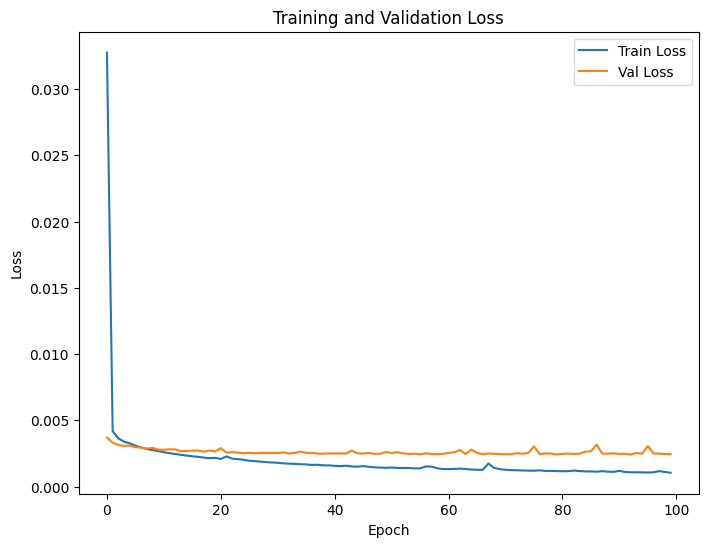

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
rgb_train, pm_train = next(iter(train_loader))
rgb_train = rgb_train[0]
pm_train = pm_train[0]

rgb_val, pm_val = next(iter(val_loader))
rgb_val = rgb_val[0]
pm_val = pm_val[0]

In [ ]:
with torch.no_grad():
    model.eval()

    rgb_train = rgb_train.unsqueeze(0).to(device)
    output_train = model(rgb_train)
    output_train = output_train.cpu().numpy()

    rgb_val = rgb_val.unsqueeze(0).to(device)
    output_val = model(rgb_val)
    output_val = output_val.cpu().numpy()

In [ ]:
# 모델 예측 결과를 시각화하는 함수
def visualize_result(rgb, pm_gt, pm_pred, is_train=True):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb.squeeze(0).permute(1, 2, 0).cpu(), aspect='auto')
    plt.colorbar()

    if is_train:
        plt.title('RGB Image (Train)')
    else:
        plt.title('RGB Image (Validation)')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_gt.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

    plt.subplot(1, 3, 3)
    plt.imshow(pm_pred.squeeze(), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Prediction)')

    plt.tight_layout()
    plt.show()

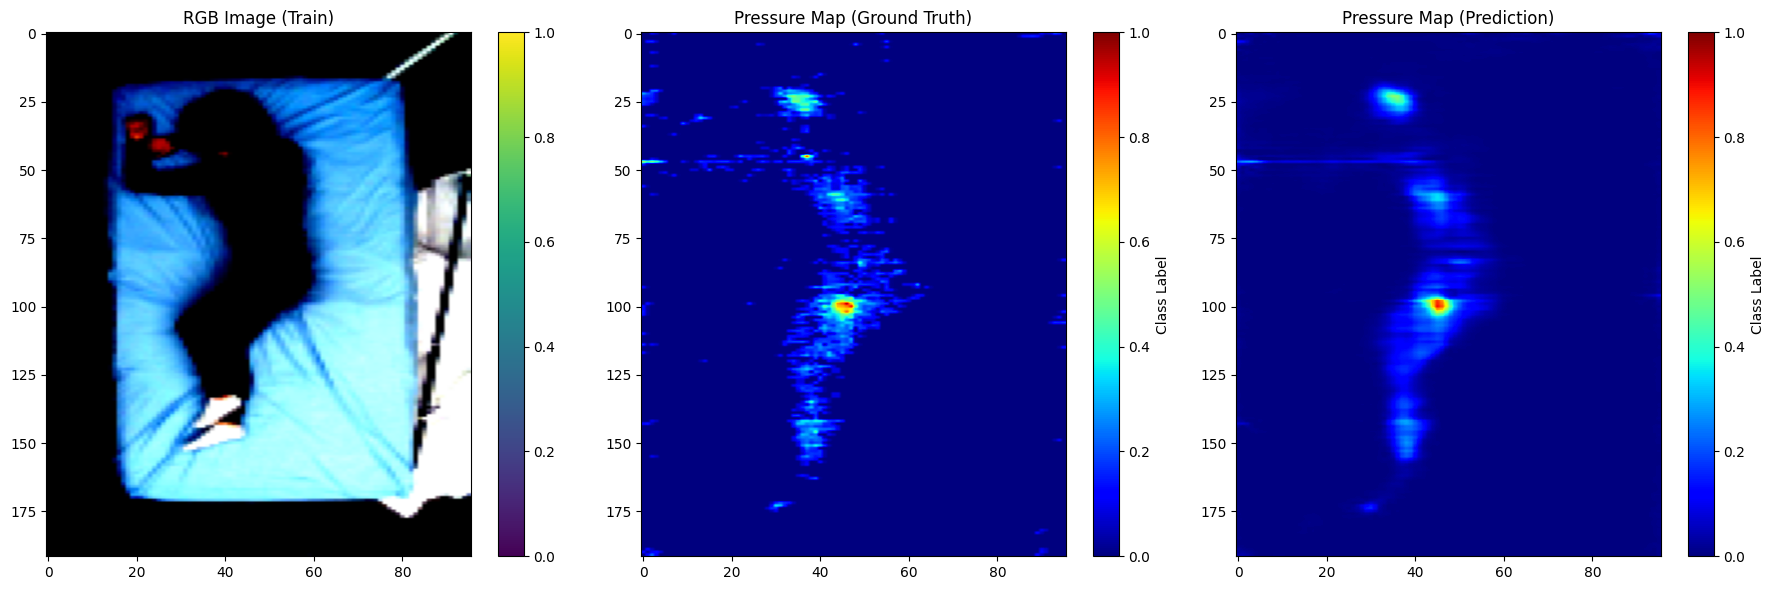

In [ ]:
# 훈련 데이터에 대한 결과 시각화
visualize_result(rgb_train, pm_train, output_train, True)

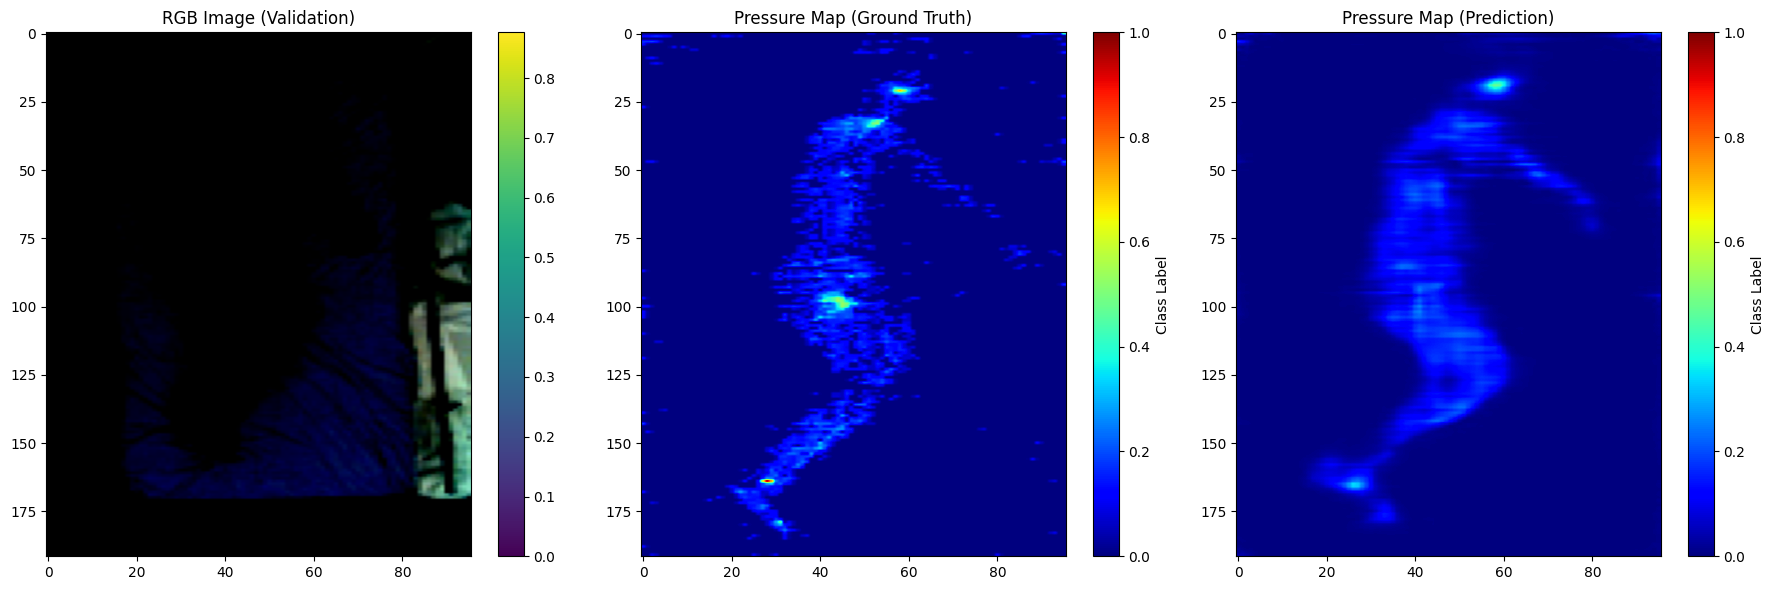

In [ ]:
# 검 데이터에 대한 결과 시각화
visualize_result(rgb_val, pm_val, output_val, False)

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save'
checkpoint_path = os.path.join(save_path, 'RGB_Reg_U-Net_100.pth')

if not os.path.exists(checkpoint_path):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
else:
    print('model save 완료.')

model save 완료.
